5 - Functional Requirements - Data Analysis and Visualization for Loan Application

In [6]:
import pymysql
import pandas as pd
import matplotlib.pyplot as plt
import pandas.io.sql as psql
import seaborn as sns

# import spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import*

from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType, DoubleType

In [7]:
# 2. Initializing SparkSession

spark = SparkSession.builder.appName("loan").getOrCreate()

5.1 Find and plot the percentage of applications approved for self-employed applicants.

In [8]:
# run the query from the database that will create spark dataframe with the result

query = "(SELECT self_employed, count(application_status), \
                (round(count(application_status)/(SELECT COUNT(Application_ID) FROM cdw_sapp_loan_application \
                WHERE application_status = 'Y')*100, 2) ) as Percent \
                FROM cdw_sapp_loan_application \
                WHERE Application_status = 'Y' \
                GROUP BY self_employed, application_status) as b"

sp_sql1 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query) \
  .load()

sp_sql1.show()


+-------------+-------------------------+-------+
|self_employed|count(application_status)|Percent|
+-------------+-------------------------+-------+
|           No|                      301|  86.74|
|          Yes|                       46|  13.26|
+-------------+-------------------------+-------+



self_employed                 object
count(application_status)      int64
Percent                      float64
dtype: object


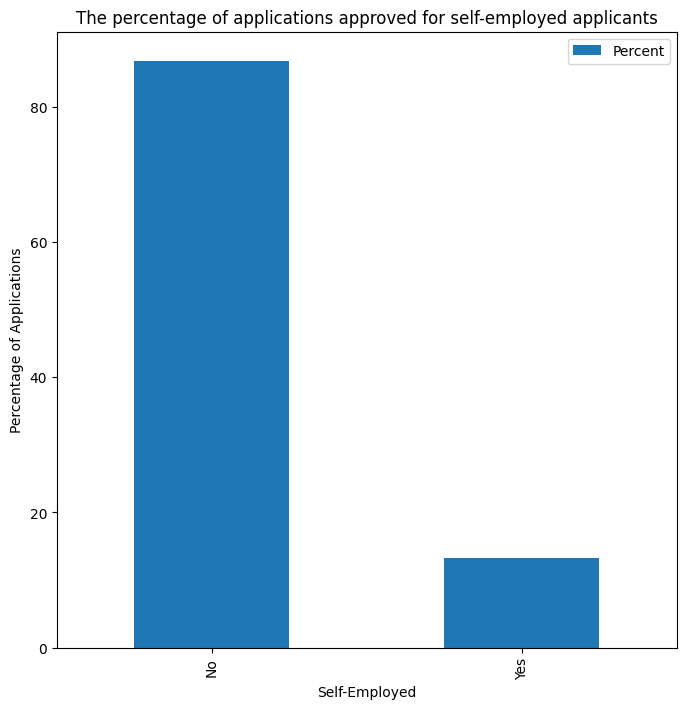

In [9]:
# import pandas as pd

pd_sql1 = sp_sql1.toPandas()

# pd_sql1.reset_index(inplace=True)
pd_sql1['Percent'] = pd_sql1['Percent'].astype('float')
print(pd_sql1.dtypes)

pd_sql1.plot(kind='bar', x='self_employed', y='Percent', figsize=(8,8))
plt.title('The percentage of applications approved for self-employed applicants')
plt.xlabel('Self-Employed')
plt.ylabel('Percentage of Applications')
plt.show()


5.2 Find the percentage of rejection for married male applicants.


In [10]:
query2 = "(SELECT application_status, COUNT(application_status) AS count_applications, \
		(round(count(application_status)/(SELECT COUNT(*) FROM cdw_sapp_loan_application \
		WHERE Gender = 'Male' AND Married = 'Yes' )*100,2)) AS Percent \
		FROM cdw_sapp_loan_application \
		WHERE Gender = 'Male' AND Married = 'Yes' \
		GROUP BY application_status) as a"

sp_sql2 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query2) \
  .load()

sp_sql2.show()


+------------------+------------------+-------+
|application_status|count_applications|Percent|
+------------------+------------------+-------+
|                 N|                87|  28.43|
|                 Y|               219|  71.57|
+------------------+------------------+-------+



application_status     object
count_applications      int64
Percent               float64
dtype: object


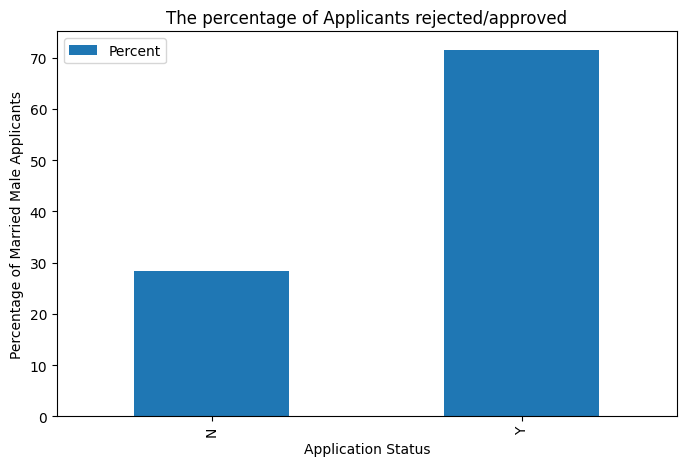

In [11]:
pd_sql2 = sp_sql2.toPandas()

# pd_sql1.reset_index(inplace=True)
pd_sql2['Percent'] = pd_sql2['Percent'].astype('float')
print(pd_sql2.dtypes)

pd_sql2.plot(kind='bar', x='application_status', y='Percent', figsize=(8,5))
plt.title('The percentage of Applicants rejected/approved')
plt.xlabel('Application Status')
plt.ylabel('Percentage of Married Male Applicants')
plt.show()


5.3 Find and plot the top three months with the largest transaction data.
Note: Take a screenshot of the graph. 


In [12]:
query3 = "(SELECT month(timeid),\
          MONTHNAME(timeid) AS Month, round(sum(TRANSACTION_value),2) AS Transaction_value\
        FROM cdw_sapp_credit_card\
        GROUP BY substr(timeid,1,6)\
        ORDER BY sum(TRANSACTION_value) DESC\
        LIMIT 3) as a"

sp_sql3 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query3) \
  .load()

sp_sql3.show()

+-------------+--------+-----------------+
|month(timeid)|   Month|Transaction_value|
+-------------+--------+-----------------+
|           10| October|        405167.78|
|            5|     May|        402620.52|
|           12|December|        402502.16|
+-------------+--------+-----------------+



month(timeid)          int32
Month                 object
Transaction_value    float64
dtype: object


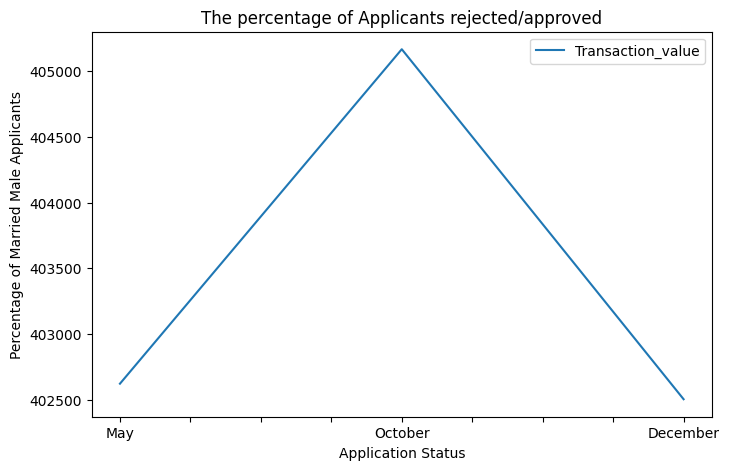

In [13]:
pd_sql3 = sp_sql3.toPandas()
pd_sql3.sort_values(by='month(timeid)', inplace=True)

# pd_sql1.reset_index(inplace=True)
pd_sql3['Transaction_value'] = pd_sql3['Transaction_value'].astype('float')
print(pd_sql3.dtypes)

pd_sql3.plot(kind='line', x='Month', y='Transaction_value', figsize=(8,5))
plt.title('The percentage of Applicants rejected/approved')
plt.xlabel('Application Status')
plt.ylabel('Percentage of Married Male Applicants')
plt.show()


5.4 Find and plot which branch processed the highest total dollar value of healthcare transactions.

In [14]:
query4 = "(SELECT branch_code, round(SUM(transaction_value),2) AS Total_Transaction_Value  \
            FROM cdw_sapp_credit_card \
            WHERE transaction_type = 'Healthcare'\
            group by branch_code \
            ORDER BY SUM(transaction_value) DESC \
            LIMIT 5) as a"

sp_sql4 = spark.read.format("jdbc") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("user", "root") \
  .option("password", "password") \
  .option("dbtable", query4) \
  .load()

sp_sql4.show()


+-----------+-----------------------+
|branch_code|Total_Transaction_Value|
+-----------+-----------------------+
|         25|                8740.36|
|         60|                8144.08|
|         83|                8006.74|
|         36|                7647.74|
|        111|                7440.54|
+-----------+-----------------------+



branch_code                  int64
Total_Transaction_Value    float64
Transaction_value          float64
dtype: object


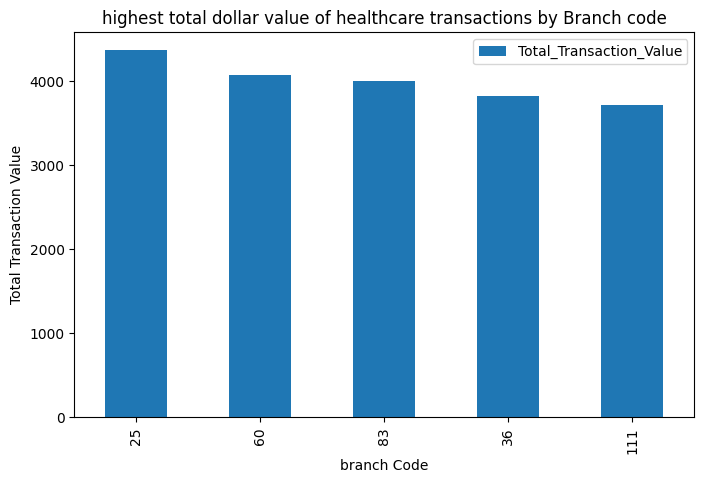

In [22]:
pd_sql4 = sp_sql4.toPandas()
# pd_sql4.sort_values(by='month(timeid)', inplace=True)

# pd_sql1.reset_index(inplace=True)
pd_sql4['Transaction_value'] = pd_sql4['Total_Transaction_Value'].astype('float')
print(pd_sql4.dtypes)

pd_sql4.plot(kind='bar', x='branch_code', y='Total_Transaction_Value', figsize=(8,5))
plt.title('highest total dollar value of healthcare transactions by Branch code')
plt.ylabel('Total Transaction Value')
plt.xlabel('branch Code')
plt.show()


In [46]:
#  read from the table into Pandas Dataframe

connection = pymysql.connect(
    host='localhost',
    user='root',
    password='password',
    database='creditcard_capstone'
)
cursor = connection.cursor()
sql = "SELECT * FROM CDW_SAPP_loan_application"
cursor.execute(sql)
result_set = cursor.fetchall()
df_pd_loan = psql.read_sql(sql, con=connection)
pd.set_option("display.max_columns", None)

C:\Users\Learner_XZHCG217\AppData\Local\Temp\ipykernel_23100\1139318155.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_pd_loan = psql.read_sql(sql, con=connection)


In [47]:
df_pd_loan.head()

,Application_ID,Gender,Married,Dependents,Education,Self_Employed,Credit_History,Property_Area,Income,Application_Status
0,LP001245,Male,Yes,2,Not Graduate,Yes,1,Semiurban,low,Y
1,LP001744,Male,No,0,Graduate,No,1,Semiurban,low,Y
2,LP001953,Male,Yes,1,Graduate,No,1,Semiurban,medium,Y
3,LP001520,Male,Yes,0,Graduate,No,1,Semiurban,medium,Y
4,LP002224,Male,No,0,Graduate,No,1,Urban,low,N
